[View in Colaboratory](https://colab.research.google.com/github/Naren-Jegan/Deep-Learning-Keras/blob/master/One_Shot_Classification_V2.ipynb)

# One Shot Learning on Omniglot Dataset

The [Omniglot](https://github.com/brendenlake/omniglot) dataset contains 1623 different handwritten characters from 50 different alphabets.
Each of the 1623 characters was drawn online via Amazon's Mechanical Turk by 20 different people.
This dataset has been the baseline for any one-shot learning algorithm.


Some of the machine learning algorithms used for learning this dataset over the years are listed below in order of accuracy:
*  Hierarchical Bayesian Program Learning - 95.2%
*  Convolutional Siamese Net                        - 92.0%
*  Affine model                                                  - 81.8%
*  Hierarchical Deep                                         - 65.2%
*  Deep Boltzmann Machine                           - 62.0%
*  Siamese Neural Net                                     - 58.3%
*  Simple Stroke                                                - 35.2%
*  1-Nearest Neighbor                                      - 21.7%


This notebook implements a [Convolutional Siamese Neural Network](https://https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) using a background set of 30 alphabets for training and evaluate on set of 20 alphabets.

# How is the data?

The Omniglot data set contains 50 alphabets total. It is split into a background set of 30 alphabets and an evaluation set of 20 alphabets.

To compare with the results in the paper [Siamese Neural Networks for One-shot Image Recognition](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf), only the background set should be used to learn general knowledge about characters (e.g., hyperparameter inference or feature learning). One-shot learning results are reported using alphabets from the evaluation set.

# Where is the data stored?

The actual zipped Omniglot dataset, extracted and processed data (Pickled data) are stored in my google drive folder named "One-Shot Classification". To mount the drive, we use 2 modules, namely:


1.   google.colab.auth - for authentication to drive
2.   google.colab.drive - for mounting from drive

# Hyper Parameter Optimisation - HyperOpt


[Hyperopt](http://github.com/hyperopt/hyperopt) is a Python library for serial and parallel optimization over awkward search spaces, which may include real-valued, discrete, and conditional dimensions.

In thiis notebook we use hyperopt trials to find the best hyper-parameters for the One-Shot Classification model. Hyperopt uses Bayesian optimization techniques to search. Tree-structured Parzen Estimator - TPE is used in this implementation.



In [1]:
!pip install -q hyperopt
from google.colab import auth, drive
auth.authenticate_user()
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Imported Normal Libraries


*   matplotlib.pyplot - To plot images
*   numpy - Tensor manipulation
*   os - File system manipulation after mounting from Drive
*   PIL.Image - To convert image files into numpy arrays
*   pickle - To store objects are files (mainly numpy arrays in this implementation)



In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from PIL import Image
import numpy.random as rnd
import pickle

# Tensorflow, Keras and Hyperopt Imports
*   **Keras**
   *  models - To create, load and save models
   *  layers - To create different types of layers
   *  preprocessing.image - To generate image transformations
   *  backend - Utilities for manipulating keras variables
   *  optimizers - To create optimizers
   *  regularizers - To create regularizers
   *  initializers - To create kernel and bias initializers
   *  legacy - To refer keras source
*  **Tensorflow**
   *  logging - To avoid unnecessary prints
   *  test - To check if GPU is available
*  **Hyperopt**
   *  hp - All randomization functions
   *  fmin - Optimization function to minimize objective
   *  tpe - Tree-structured Parzen Estimator
   *  Trails - Object to hold each run information
   *  STATUS_OK - Flag to indicate trial was successful

In [3]:
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import InputLayer, Input, Lambda
from tensorflow.python.keras.layers import Reshape, MaxPooling2D, BatchNormalization
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.optimizers import Optimizer
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.initializers import RandomNormal
from tensorflow import test, logging
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from keras.legacy import interfaces
test.gpu_device_name()

Using TensorFlow backend.


'/device:GPU:0'

In [4]:
tf.__version__

'1.12.0-rc1'

# File System Structure

One-Shot Classification


* Background
  * Alphabet_of_the_Magi
    *  character01
      *  0709_01.png
      *  0709_02.png
      *  .
      *  .
      *  .
    *  character02
    *  .
    *  .
    *  .
  * Anglo-Saxon_Futhorc
  * .
  * .
  * .

* Evaluation
  * Angelic
    *  character01
      *  0965_01.png
      *  0965_02.png
      *  .
      *  .
      *  .
    *  character02
    *  .
    *  .
    *  .
  * Atemayar_Qelisayer
  * .
  * .
  * .




In [0]:
#path to main folder
one_shot_path = os.path.join("drive", "My Drive", "Colab Notebooks", "One-Shot Classification")

#path to background and evaluation data
background_path = os.path.join(one_shot_path, "background")
evaluation_path = os.path.join(one_shot_path, "evaluation")

#path to final model
recognition_model_path = os.path.join(one_shot_path, "recognition_model.h5")

#seed
seed = 20

# Preprocessing and Pickling

Both the training and test data are converted in a 4 dimensional array of the following form,

>(Character_id, Writer_id, Pixel_X, Pixel_Y)

> where,


*   Character_id - number given in the filename as **number**_writer.png
*   Writer_id - writer given in the filename as number_**writer**.png
*   Pixel_X - X coordinate of pixel value
*   Pixel_Y - Y coordinate of pixel value

Along with this data, store a mapping contating the alphabets and it's starting character_id number



In [0]:
##creating training set
train_data = np.ndarray(shape=(964, 20, 105, 105))
train_alphabets = dict()

#Preprocessing
#for alphabet in os.listdir(background_path):
#  alphabet_path = os.path.join(background_path, alphabet)
#  for character in os.listdir(alphabet_path):
#    character_path = os.path.join(alphabet_path, character)
#    for image in os.listdir(character_path):
#      index = int(image[0:4]) - 1
#      writer = int(image[5:7]) - 1
#      train_data[index][writer] = np.array(Image.open(os.path.join(character_path, image)))
#      train_alphabets[alphabet] = index if alphabet not in train_alphabets or train_alphabets[alphabet] > index else train_alphabets[alphabet]

#with open(os.path.join("train.pickle"), 'wb') as f:
#  pickle.dump([train_data, train_alphabets], f, protocol=2)

##creating test set
test_data = np.ndarray(shape=(659, 20, 105, 105))
test_alphabets = dict()

#Preprocessing
#for alphabet in os.listdir(evaluation_path):
#  alphabet_path = os.path.join(evaluation_path, alphabet)
#  for character in os.listdir(alphabet_path):
#    character_path = os.path.join(alphabet_path, character)
#    for image in os.listdir(character_path):
#      index = int(image[0:4]) - 965
#      writer = int(image[5:7]) - 1
#      test_data[index][writer] = np.array(Image.open(os.path.join(character_path, image)))
#      test_alphabets[alphabet] = index if alphabet not in test_alphabets or test_alphabets[alphabet] > index else test_alphabets[alphabet]

#with open(os.path.join("test.pickle"), 'wb') as f:
#  pickle.dump([test_data, test_alphabets], f, protocol=2)

Loading Preprocessed training and test data (train.pickle and test.pickle)

In [0]:
with open(os.path.join(one_shot_path, "train.pickle"), 'rb') as f:
  train_data, train_alphabets = pickle.load(f, encoding='latin1')
  
with open(os.path.join(one_shot_path, "test.pickle"), 'rb') as f:
  test_data, test_alphabets = pickle.load(f, encoding='latin1')

In [0]:
batch_size = 128
image_size = 105

# Image Augmentation Ranges
During data generation, images are transformed to provide a more robust training. The parameters for the transformations are defined as follows:

*   Rotation Range - maximum degrees upto which image can be rotated clockwise and anti-clockwise
*   Width Shift Range - maximum number of pixels upto which image can be shifted to the left or right
*   Height Shift Range - maximum number of pixels upto which image can be shifted to the up or down
*   Shear Range - maximum degree of shearing allowed
*   Zoom Range



In [0]:
#@title Data Augmentation
rotation_range = 10 #@param {type:"slider", min:0, max:90, step:1}
width_shift_range = 2 #@param {type:"slider", min:0, max:10, step:0.1}
height_shift_range = 2 #@param {type:"slider", min:0, max:10, step:0.1}
shear_range = 0.3 #@param {type:"slider", min:0, max:1, step:0.1}
zoom_range = 0.2 #@param {type:"slider", min:0, max:1, step:0.01}

# Batch Generation


*   Create X1, X2 which will contain batch_size number of images paired against one other for comparison 
*   Create Y which will contain the results of comparison for the whole batch
*   Each alphabet should get equal representation in the training
  *  s_alphabets -> alphabet's starting character_ids in sorted order
  *  times -> number of times each alphabet can be represented in a single batch equally for both same and different pairs
  *  reminder -> number of times alphabets have to be picked at random cause batch size is not a multiple of the number of alphabets
*  For each alphabet chosen, create same (writer) and different (character) pairs
  *  w_range -> writers to chose from
  *  c_range -> characters to choose from
  *  transform_image -> image augmentation function
*  Yield created batch



In [0]:
# this is the augmentation configuration we will use for training
datagen = ImageDataGenerator()

def transform_image(image):
  return datagen.apply_transform(image.reshape((image_size, image_size, 1)), 
                                 transform_parameters = 
                       {'theta': rnd.uniform(-rotation_range, rotation_range),
                        'tx'   : rnd.uniform(-width_shift_range, width_shift_range),
                        'ty'   : rnd.uniform(-height_shift_range, height_shift_range),
                        'shear': rnd.uniform(-shear_range, shear_range),
                        'zx'   : rnd.uniform(-zoom_range, zoom_range),
                        'zy'   : rnd.uniform(-zoom_range, zoom_range)
                       })

#generate image pairs [x1, x2] with target y = 1/0 representing same/different
def datagen_flow(datagen):
    while True:
      X1 = np.ndarray(shape=(batch_size, image_size, image_size, 1))
      X2 = np.ndarray(shape=(batch_size, image_size, image_size, 1))
      Y = np.ndarray(shape=(batch_size,))
      
      s_alphabets = sorted(train_alphabets.values())
      a_indices = list(range(len(s_alphabets)))
      times = batch_size//(2*len(a_indices))
      remainder = (batch_size//2)%len(a_indices)
      
      aindices = a_indices*times + list(rnd.choice(a_indices, remainder))
      rnd.shuffle(aindices)
      
      w_range = list(range(20))
      
      i = 0   
      for a in aindices:
        end_index = (len(train_data) if a+1 == len(s_alphabets) else s_alphabets[a+1])
        c_range = list(range(s_alphabets[a], end_index))
        
        writers = rnd.choice(w_range, 2)
        same = rnd.choice(c_range)
        X1[2*i] = transform_image(train_data[same, writers[0]])
        X2[2*i] = transform_image(train_data[same, writers[1]])
        Y[2*i] = 1.0
        
        writers = rnd.choice(w_range, 2)
        diff = rnd.choice(c_range, 2)
        X1[2*i + 1] = transform_image(train_data[diff[0], writers[0]])
        X2[2*i + 1] = transform_image(train_data[diff[1], writers[1]])
        Y[2*i + 1] = 0.0
        
        i += 1
        
      yield [X1, X2], Y

train_generator = datagen_flow(datagen)

# Modification of Keras SGD Optimizer
A few modifications have been done to the original Keras SGD optimizer to include

*   Learning rate for each layer
*   Maximum momentum for each layer
*   Linearly increase momentum from 0.5 to Maximum momemtum based on the number of epochs



In [0]:
class Modified_SGD(Optimizer):
    """ Modified Stochastic gradient descent optimizer.
    Reorganized SGD to allow layer-wise momentum and learning-rate
    Includes support for momentum,
    learning rate decay, and Nesterov momentum.
    Includes the possibility to add multipliers to different
    learning rates in each layer.
    # Arguments
        lr: float >= 0. Learning rate.
        momentum: float >= 0. Parameter updates momentum.
        decay: float >= 0. Learning rate decay over each update.
        nesterov: boolean. Whether to apply Nesterov momentum.
        lr_values: dictionary with learning rate for a specific layer
        for example:
            # Setting the Learning rate multipliers
            lr_values = {}
            lr_values['conv1']=1
        momentum_values: dictionary with momentum for a specific layer
    """

    def __init__(self, lr=1, momentum=0.5, decay=0., n_epochs=200,
                 nesterov=False, lr_values=None, momentum_values=None, **kwargs):
        super(Modified_SGD, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.momentum = K.variable(momentum, name='momentum')
            self.decay = K.variable(decay, name='decay')
        self.initial_decay = decay
        self.nesterov = nesterov
        self.lr_values = lr_values
        self.momentum_values = momentum_values
        self.n_epochs = n_epochs

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * K.cast(self.iterations,
                                                  K.dtype(self.decay))))
        
        
        # momentum
        shapes = [K.int_shape(p) for p in params]
        moments = [K.zeros(shape) for shape in shapes]
        self.weights = [self.iterations] + moments
        for p, g, m in zip(params, grads, moments):

            if self.lr_values != None:
                if p.name in self.lr_values:
                    new_lr = lr * self.lr_values[p.name]
                else:
                    new_lr = lr
            else:
                new_lr = lr

            if self.momentum_values != None:
                if p.name in self.momentum_values:
                    new_momentum = ((self.momentum_values[p.name] - self.momentum)/self.n_epochs)*self.iterations + self.momentum  
                else:
                    new_momentum = self.momentum
            else:
                new_momentum = self.momentum
            
            # velocity
            v = new_momentum * m - new_lr * g  
            self.updates.append(K.update(m, v))

            if self.nesterov:
                new_p = p + new_momentum * v - new_lr * g
            else:
                new_p = p + v

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'momentum': float(K.get_value(self.momentum)),
                  'decay': float(K.get_value(self.decay)),
                  'nesterov': self.nesterov,
                  'lr_values': self.lr_values,
                  'momentum_values': self.momentum_values}
        base_config = super(Modified_SGD, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# Weight and Bias Initilization
*  Weights are randomly initialized with a mean 0 and standard deviation 0.01 over a normal distribution
*  Biases are randomly initialized with a mean 0.5 and standard deviation 0.01 over a normal distribution

In [0]:
w_init = RandomNormal(mean=0.0, stddev=1e-2, seed=seed)
b_init = RandomNormal(mean=0.5, stddev=1e-2, seed=seed)

#image shape
input_shape=(image_size, image_size, 1)

# 20-Way One-Shot Classification Task
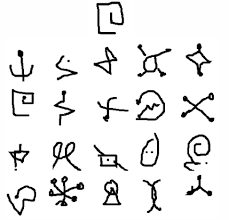

For validating and testing, twice for every alphabet (10 for each validation and test),
*   Randomly select 20 characters
*   Randomly select 2 writers
*   For each character chosen:
  *  X1 -> 20 copies of the character written by the first writer
  *  X2 -> all 20 characters by the second writer
  *  check if the prediction for [X1, X2] as input activates the correct character
  *  If correct count it
*  Finally accuracy -> count/2\*20\*no_of_alphabets -> count/400

In [0]:
def validate(model, test = False, show = False):
  N = 20
  
  st_alphabets = sorted(test_alphabets.values())
  max_index = len(test_data) if test else st_alphabets[10]
  st_alphabets = st_alphabets[10:20] if test else st_alphabets[0:10]
  correct = 0
  for i in range(len(st_alphabets)):
    end_index = max_index if i+1 == len(st_alphabets) else st_alphabets[i+1] 
    c_range = list(range(st_alphabets[i],end_index))

    for j in range(2):
      c_list = rnd.choice(c_range, N)
      w_list = rnd.choice(range(20), 2)

      for c_i in range(N):
        image = test_data[c_list[c_i]][w_list[0]]

        X1 = np.array([image]*N).reshape((N, image_size, image_size, 1))
        X2 = np.array(test_data[c_list][w_list[1]]).reshape((N, image_size, image_size, 1))
        if show and c_i == 2 and i == 3:
          plt.imshow(image)
          plt.show()
          for m in range(N):
            plt.imshow(test_data[c_list[m]][w_list[1]])
            plt.show()


        targets = np.zeros((N,))
        targets[c_i] = 1
        predictions = model.predict([X1, X2])

        if show and c_i == 2 and i == 3:
          print(targets)
          print(predictions)
          show = False
          print(np.argmax(predictions))
        if(np.argmax(predictions) == np.argmax(targets)):
          correct += 1
  return (100*correct/(N*10*2))

Reduce learning rate by 1% after each epoch

In [0]:
#CallBacks
from tensorflow.python.keras.callbacks import LearningRateScheduler, ModelCheckpoint

lr_scheduler = LearningRateScheduler(lambda epoch, lr: 0.99*lr)
model_saver = ModelCheckpoint(recognition_model_path, monitor='loss')


# One-Shot Model building, compiling, fitting and validating

**Model Architecture**

![One Shot Model Architecture](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQThMusu8b2uK8kGwrFsg-cuZXaN8Wc7HkfgyiM-8YAfCfN_2uiJQ)

**Model Keras Design**

*  The model in the image is created by creating a Sequential keras model until the fully connected layer
  *  Each layer has it's own regularization parameter and a batch normalizer
*  A Lambda layer is introduced to perform a L1 distance calculation between the 4096 embedding outputs of the twin networks
* The L1 distance is then given to a sigmoid to classify as same/different (1/0)
*  Finally this is wrapped up in a functional model that takes 2 input images for the twin networks and outputs the sigmoid value of the L1 distance

**Model Compilation:**
The above mentioned model is compiled with the modified SGD optimizer, binary_crossentropy loss and accuracy as the metric

**Model Fitting:**
The model is then trained for the given n_epochs, each epoch training on steps_per_epoch number of  batchs with the given starting learning rates for each layer and final momentums for each layer

**Model Validation:**
The model trained thus is validated using the validate function defined earlier and the negative of validation accuracy is returned for the hyper-parameter optimization procedure to minimize


In [0]:
def One_Shot_Model(params, save=False, verbose=False):
  
  print(params)
  
  lr_values = dict()
  lr_values['layer_conv1'] = params['l_c1']
  lr_values['layer_conv2'] = params['l_c2']
  lr_values['layer_conv3'] = params['l_c3']
  lr_values['layer_conv4'] = params['l_c4']
  lr_values['layer_dense1'] = params['l_d1']
  
  momentum_values = dict()
  momentum_values['layer_conv1'] = params['m_c1']
  momentum_values['layer_conv2'] = params['m_c2']
  momentum_values['layer_conv3'] = params['m_c3']
  momentum_values['layer_conv4'] = params['m_c4']
  momentum_values['layer_dense1'] = params['m_d1']
  
  reg_values = dict()
  reg_values['layer_conv1'] = params['r_c1']
  reg_values['layer_conv2'] = params['r_c2']
  reg_values['layer_conv3'] = params['r_c3']
  reg_values['layer_conv4'] = params['r_c4']
  reg_values['layer_dense1'] = params['r_d1']
  
  left_input = Input(input_shape)
  right_input = Input(input_shape)

  # Start construction of the Keras Sequential model.
  convnet = Sequential()

  # First convolutional layer with activation, batchnorm and max-pooling.
  convnet.add(Conv2D(kernel_size=10, strides=1, filters=64, padding='valid',
                     input_shape=input_shape, bias_initializer=b_init,
                     activation='relu',
                     name='layer_conv1', kernel_regularizer=l2(reg_values['layer_conv1'])))
  convnet.add(BatchNormalization(axis = 3, name = 'bn1'))
  convnet.add(MaxPooling2D(pool_size=2, strides=2, name="max_pooling1"))

  # Second convolutional layer with activation, batchnorm and max-pooling.
  convnet.add(Conv2D(kernel_size=7, strides=1, filters=128, padding='valid',
                    kernel_initializer=w_init, bias_initializer=b_init,
                    activation='relu', 
                    name='layer_conv2', kernel_regularizer=l2(reg_values['layer_conv2'])))
  convnet.add(BatchNormalization(axis = 3, name = 'bn2'))
  convnet.add(MaxPooling2D(pool_size=2, strides=2, name="max_pooling2"))

  # Third convolutional layer with activation, batchnorm and max-pooling.
  convnet.add(Conv2D(kernel_size=4, strides=1, filters=128, padding='valid',
                    kernel_initializer=w_init, bias_initializer=b_init,
                    activation='relu', 
                    name='layer_conv3', kernel_regularizer=l2(reg_values['layer_conv3'])))
  convnet.add(BatchNormalization(axis = 3, name = 'bn3'))
  convnet.add(MaxPooling2D(pool_size=2, strides=2, name="max_pooling3"))

  # Fourth convolutional layer with activation, batchnorm and max-pooling.
  convnet.add(Conv2D(kernel_size=4, strides=1, filters=256, padding='valid',
                    kernel_initializer=w_init, bias_initializer=b_init,
                    activation='relu', 
                    name='layer_conv4', kernel_regularizer=l2(reg_values['layer_conv4'])))
  convnet.add(BatchNormalization(axis = 3, name = 'bn4'))
  convnet.add(MaxPooling2D(pool_size=2, strides=2, name="max_pooling4"))

  # Flatten the 4-rank output of the convolutional layers
  # to 2-rank that can be input to a fully-connected / dense layer.
  convnet.add(Flatten())


  # First fully-connected / dense layer with activation.
  convnet.add(Dense(4096, activation='sigmoid',
                   kernel_initializer=w_init, bias_initializer=b_init,
                   name = "layer_dense1", kernel_regularizer=l2(reg_values['layer_dense1'])))
  convnet.add(BatchNormalization(axis = 1, name = 'bn5'))

  #call the convnet Sequential model on each of the input tensors so params will be shared
  encoded_l = convnet(left_input)
  encoded_r = convnet(right_input)

  #layer to merge two encoded inputs with the l1 distance between them
  L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))

  #call this layer on list of two input tensors.
  L1_distance = L1_layer([encoded_l, encoded_r])

  prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
  
  model = Model(inputs=[left_input,right_input],outputs=prediction)
  
  optimizer = Modified_SGD(lr=1, lr_values=lr_values, momentum_values=momentum_values, momentum=0.5, n_epochs=params['epochs'])
  
  model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
  
  callbacks = [lr_scheduler, model_saver] if save else [lr_scheduler]
  
  history = model.fit_generator(
      train_generator,
      steps_per_epoch=params['steps_per_epoch'],
      epochs=params['epochs'],
      callbacks=callbacks,
      verbose=verbose
  )
  val_acc = validate(model)
  loss_history = history.history['loss']
  print('Validation accuracy:', val_acc)
  return {'loss': loss_history[len(loss_history) - 1]-val_acc, 'status': STATUS_OK, 'model': model}

In [0]:
trials_path = os.path.join(one_shot_path, 'trials.hyperopt')
trials=Trials()

#with open(trials_path, 'wb') as f:
#  pickle.dump(trials, f, -1)

# Hyper-Parameter Optimization Space
*  Learning rates for each layer - [0.0001, 0.1]
*  Final momentum for each layer - [0.5, 1]
*  Regularization Parameter - [0, 0.1]

In the original paper, each epoch trained a maximum of 150,000 pairs of images, equvalent to around 1200 batches where batch size is 128. But due to the lack of computational power and the fact that a single 200 epoch training with 100 batches each takes about 1-2 hours in a GPU, the number of batches per epoch in this implementation has been reduced.


In [0]:
space = {
    'l_c1' : 10 ** hp.uniform('l_c1', -4, -1),
    'l_c2' : 10 ** hp.uniform('l_c2', -4, -1),
    'l_c3' : 10 ** hp.uniform('l_c3', -4, -1),
    'l_c4' : 10 ** hp.uniform('l_c4', -4, -1),
    'l_d1' : 10 ** hp.uniform('l_d1', -4, -1),
    'm_c1' : hp.uniform('m_c1', 0.5, 1),
    'm_c2' : hp.uniform('m_c2', 0.5, 1),
    'm_c3' : hp.uniform('m_c3', 0.5, 1),
    'm_c4' : hp.uniform('m_c4', 0.5, 1),
    'm_d1' : hp.uniform('m_d1', 0.5, 1),
    'r_c1' : hp.uniform('r_c1', 0, 0.1),
    'r_c2' : hp.uniform('r_c2', 0, 0.1),
    'r_c3' : hp.uniform('r_c3', 0, 0.1),
    'r_c4' : hp.uniform('r_c4', 0, 0.1),
    'r_d1' : hp.uniform('r_d1', 0, 0.1),
    'epochs' : 25,
    'steps_per_epoch' : 25
}

**Save Optimization state by pickling Trials object after each trial/run.**

**In this implementation, 1000 trials are run to find the optimal hyperparameters.**

**SInce Keras models are not serializable, the models themselves are not saved. After finding the best hyperparameters, a final model is trained using them and stored as the best model.**

In [0]:
def remove_models(trials):
    for trial in trials.trials:
      if 'result' in trial.keys() and 'model' in trial['result'].keys():
          trial['result'].pop('model', None)

In [0]:
with open(trials_path, 'rb') as f:
    trials = pickle.load(f, encoding='latin1')
print(len(trials))
while(len(trials) < 1000): 

  best = fmin(One_Shot_Model, space, algo=tpe.suggest, trials=trials, max_evals=len(trials) + 1)
 
  remove_models(trials)

  with open(trials_path, 'wb') as f:
    pickle.dump(trials, f, -1)

131
{'epochs': 25, 'l_c1': 0.0002582326161233065, 'l_c2': 0.008672683803457768, 'l_c3': 0.0026730602538495387, 'l_c4': 0.031055902033444105, 'l_d1': 0.0005372332342573101, 'm_c1': 0.6697122515837497, 'm_c2': 0.7117174947410375, 'm_c3': 0.5353048847741525, 'm_c4': 0.8631329285868382, 'm_d1': 0.9177947512464393, 'r_c1': 0.07451725033897806, 'r_c2': 0.003877271726929171, 'r_c3': 0.04870489307645327, 'r_c4': 0.012049313147480575, 'r_d1': 0.018545863798019233, 'steps_per_epoch': 25}
Validation accuracy: 4.5
{'epochs': 25, 'l_c1': 0.013356056291617837, 'l_c2': 0.004035205878074567, 'l_c3': 0.0006079417371728566, 'l_c4': 0.08459204144370798, 'l_d1': 0.03213924928984598, 'm_c1': 0.9945148559513387, 'm_c2': 0.896354510018336, 'm_c3': 0.7424618202586746, 'm_c4': 0.841247868004208, 'm_d1': 0.8230988720035588, 'r_c1': 0.08850477199108944, 'r_c2': 0.031255183939068, 'r_c3': 0.08147636837803693, 'r_c4': 0.06974387242439561, 'r_d1': 0.02208267353379026, 'steps_per_epoch': 25}
Validation accuracy: 4.5

In [33]:
print("Best performing model chosen hyper-parameters:")
hypms = trials.best_trial['misc']['vals']
space = {
    'l_c1' : 10 ** hypms['l_c1'][0],
    'l_c2' : 10 ** hypms['l_c2'][0],
    'l_c3' : 10 ** hypms['l_c3'][0],
    'l_c4' : 10 ** hypms['l_c4'][0],
    'l_d1' : 10 ** hypms['l_d1'][0],
    'm_c1' : hypms['m_c1'][0],
    'm_c2' : hypms['m_c2'][0],
    'm_c3' : hypms['m_c3'][0],
    'm_c4' : hypms['m_c4'][0],
    'm_d1' : hypms['m_d1'][0],
    'r_c1' : hypms['r_c1'][0],
    'r_c2' : hypms['r_c2'][0],
    'r_c3' : hypms['r_c3'][0],
    'r_c4' : hypms['r_c4'][0],
    'r_d1' : hypms['r_d1'][0],
    'epochs' : 200,
    'steps_per_epoch' : 400
}
logging.set_verbosity(tf.logging.INFO)
print(One_Shot_Model(space, verbose=True))
logging.set_verbosity(tf.logging.ERROR)

Best performing model chosen hyper-parameters:
{'l_c1': 0.014538826898713204, 'l_c2': 0.00010919842686087119, 'l_c3': 0.00038125216225626474, 'l_c4': 0.008770377956002638, 'l_d1': 0.00011678380047227724, 'm_c1': 0.9551356417451297, 'm_c2': 0.9054181789527249, 'm_c3': 0.8647945727383626, 'm_c4': 0.739005033791005, 'm_d1': 0.6604686266123321, 'r_c1': 0.041878663168265065, 'r_c2': 0.07622517242755658, 'r_c3': 0.09620024375288616, 'r_c4': 0.04602820869861393, 'r_d1': 0.047415925400307646, 'epochs': 1, 'steps_per_epoch': 400}
Epoch 1/1
400/400 [==============================] - 189s 471ms/step - loss: 205244.9756 - acc: 0.5000
Validation accuracy: 2.5
{'loss': -2.5, 'status': 'ok', 'model': <tensorflow.python.keras.engine.training.Model object at 0x7f12d960f9b0>}


In [0]:
model = load_model(recognition_model_path, custom_objects = {"Modified_SGD": Modified_SGD})


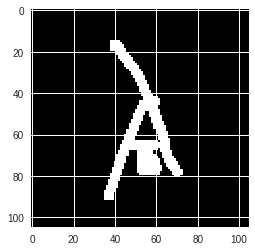

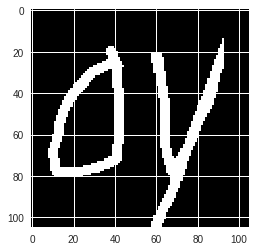

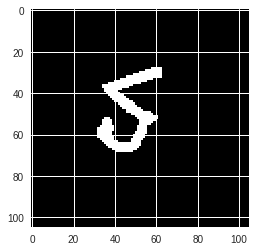

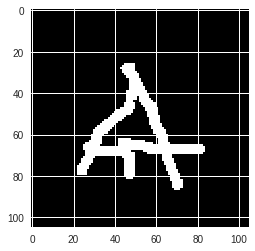

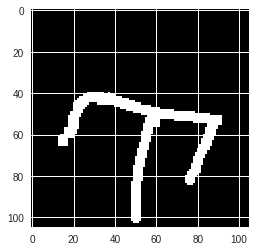

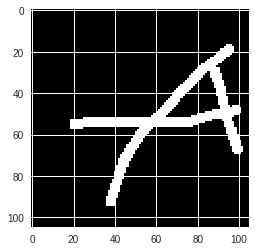

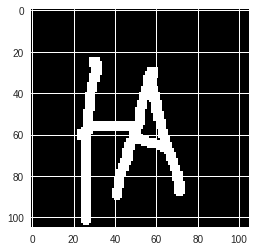

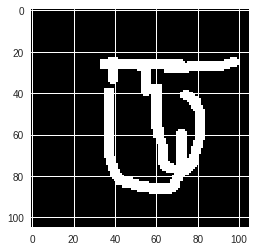

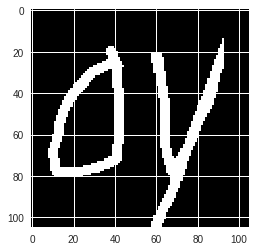

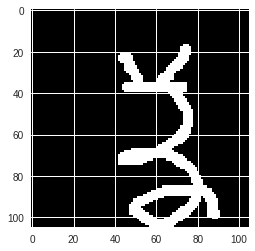

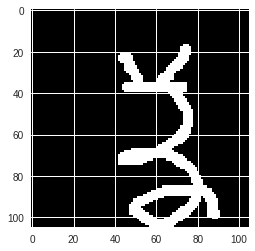

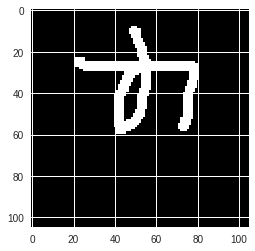

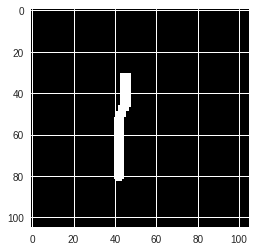

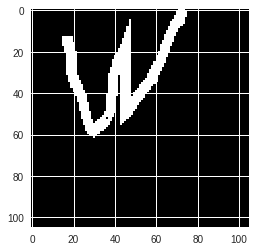

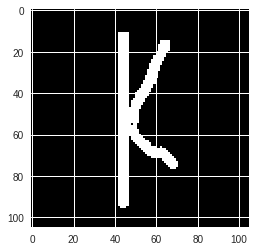

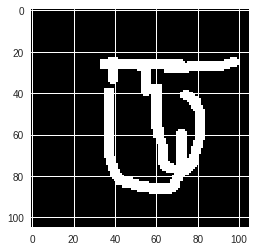

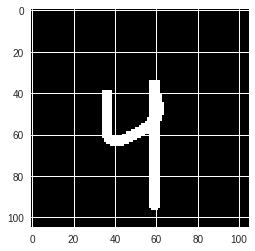

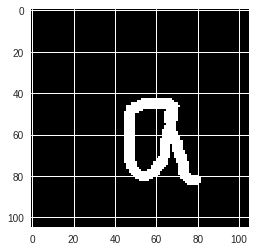

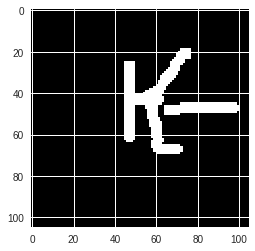

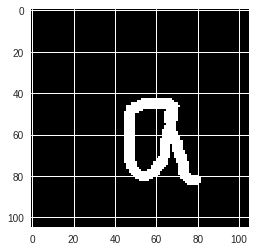

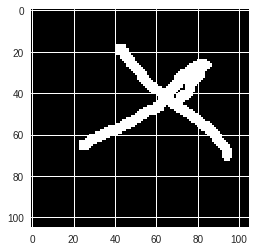

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[0.53625417]
 [0.5342079 ]
 [0.536861  ]
 [0.5366274 ]
 [0.53691334]
 [0.5359955 ]
 [0.53742427]
 [0.535998  ]
 [0.5362115 ]
 [0.53737277]
 [0.53463334]
 [0.53672314]
 [0.53610915]
 [0.5367341 ]
 [0.5379994 ]
 [0.53693223]
 [0.5356431 ]
 [0.5362505 ]
 [0.5367576 ]
 [0.5370039 ]]
14
6.0


In [22]:
print(validate(model, test=True, show=True))